# Deep Learning Project
## Istanbul Technical University
### Computer Engineering Department
### BLG 527E - Deep Learning
### Fall 2023

<b>Student Name: Muhammed Rüşen Birben</b><br>
<b>Student ID: 150220755</b><br>
<b>Student Email: birben20@itu.edu.tr</b><br>

<b>Student Name: Ahmed Burak Ercan</b><br>
<b>Student ID: 150220749</b><br>
<b>Student Email: ercana20@itu.edu.tr</b><br>

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from os import makedirs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from collections import Counter
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
# custom modules
import Scripts.utils
import Scripts.model
# Reloading custom modules, for production purposes
reload(Scripts.utils)
reload(Scripts.model)
from Scripts.utils import get_model, model_predict, eval_model
from Scripts.model import TextDataset

In [2]:
def seed_everything(seed_value=42):
    """
    Seed random number generators to ensure reproducibility.
    Args:
    seed_value (int): The seed value to use for all random number generators.
    """
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Usage:
seed_everything()  # Call the function with default seed=42 or pass a specific seed value if needed.

### Loading the Data

In [3]:
# Reading the data.
df = pd.read_csv('Data/final_data.csv')
print(f"Lenght of the dataset: {len(df)}")
df.head()

Lenght of the dataset: 26270


,Source,Text,IsAI
0,LLM,Have you ever heard of the Crusades? A time in...,yes
1,LLM,"The professors, who likely have nearly a decad...",yes
2,LLM,Kemba Walker does a good job of defending Foye...,yes
3,LLM,"Ganias' lawyer, Stanley Twardy, urged the gove...",yes
4,PDF,The Circuit Court of Appeals of New Jersey had...,no


In [4]:
# map yes/no to 1/0
df['IsAI'] = df['IsAI'].map({'yes': 1, 'no': 0})
# rename column IsAI to labels
df.rename(columns={'IsAI': 'labels'}, inplace=True)
# rename columns to lowercase
df.columns = df.columns.str.lower()

In [5]:
df.dropna(inplace=True)

In [6]:
# Splitting the DataFrame into train and remaining datasets
# get a portion of the dataset
df = df.sample(frac=1, random_state=42)

# Splitting the DataFrame into train and validation and test datasets
train_df, test_df = train_test_split(df[['labels', 'text']], test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# length of the datasets
print(f"Length of the train dataset: {len(train_df)}")
print(f"Length of the validation dataset: {len(val_df)}")
print(f"Length of the test dataset: {len(test_df)}")

# see if conda is available on torch
print(f"Cuda is available: {(device:=torch.cuda.is_available())}")



Length of the train dataset: 8406
Length of the validation dataset: 2102
Length of the test dataset: 2627
Cuda is available: True


### Model Development

In [7]:
# setting up three models
model_names = ["roberta-base-openai-detector", "chatgpt-detector-roberta", "chatgpt-detector-lli-hc3"]
models = dict()
model_tokenizers = dict()

for model_name in model_names:
    models[model_name], model_tokenizers[model_name] = get_model(model_name)
    if device: models[model_name].cuda()

Model roberta-base-openai-detector already exists, loading...


Model chatgpt-detector-roberta already exists, loading...
Model chatgpt-detector-lli-hc3 already exists, loading...


testing the out-of-the-box models on the dataset

In [8]:
# test all three models on the same data
model_confusion_matrices = {}
model_scores_before_finetuning = {}
for i, model_name in enumerate(model_names):
    print(model_name)
    predictions = model_predict(models[model_name], model_tokenizers[model_name], test_df['text'].tolist())
    model_confusion_matrices[model_name], scores = eval_model(predictions, test_df['labels'].tolist(), return_scores=True)
    model_scores_before_finetuning[model_names[i]] = {k: v for k, v in zip(["accuracy", "recall", "precision", "f1"], scores)}
    print("-"*50)

roberta-base-openai-detector


100%|██████████| 27/27 [00:17<00:00,  1.52it/s]


Accuracy: 58.32%
Recall: 58.31%
Precision: 58.32%
F1-score: 58.30%
--------------------------------------------------
chatgpt-detector-roberta


100%|██████████| 27/27 [00:17<00:00,  1.56it/s]


Accuracy: 60.07%
Recall: 60.11%
Precision: 61.22%
F1-score: 59.07%
--------------------------------------------------
chatgpt-detector-lli-hc3


100%|██████████| 27/27 [00:18<00:00,  1.48it/s]

Accuracy: 44.08%
Recall: 44.04%
Precision: 43.29%
F1-score: 42.45%
--------------------------------------------------


### Fine-Tuning

tokenizing the data for each model

In [9]:
tokenized_datasets = dict()

# Convert DataFrame to Hugging Face Dataset
train_df = Dataset.from_pandas(train_df)
val_df = Dataset.from_pandas(val_df)
test_df = Dataset.from_pandas(test_df)

# Tokenization
def tokenize_function(data, tokenizer):
    return tokenizer(data["text"], padding="max_length", truncation=True, max_length=64)


for model_name in model_names:
    tokenized_train = train_df.map(lambda examples: tokenize_function(examples, model_tokenizers[model_name]), batched=True)
    tokenized_val = val_df.map(lambda examples: tokenize_function(examples, model_tokenizers[model_name]), batched=True)
    tokenized_test = test_df.map(lambda examples: tokenize_function(examples, model_tokenizers[model_name]), batched=True)
    tokenized_datasets[model_name] = {"train": tokenized_train, "val": tokenized_val, "test": tokenized_test}

Map:   0%|          | 0/8406 [00:00<?, ? examples/s]

Map:   0%|          | 0/2102 [00:00<?, ? examples/s]

Map:   0%|          | 0/2627 [00:00<?, ? examples/s]

Map:   0%|          | 0/8406 [00:00<?, ? examples/s]

Map:   0%|          | 0/2102 [00:00<?, ? examples/s]

Map:   0%|          | 0/2627 [00:00<?, ? examples/s]

Map:   0%|          | 0/8406 [00:00<?, ? examples/s]

Map:   0%|          | 0/2102 [00:00<?, ? examples/s]

Map:   0%|          | 0/2627 [00:00<?, ? examples/s]

In [10]:
def majority_voting(predictions):
  majority_votes = []

  for i in range(len(predictions[0])):
      votes = [predictions[0][i], predictions[1][i], predictions[2][i]]
      vote_count = Counter(votes)
      majority_vote = max(vote_count, key=vote_count.get)
      majority_votes.append(majority_vote)

  return majority_votes

In [11]:
fine_tuned_model_confusion_matrices = {}
model_scores = {}
all_predictions = []

# Define training arguments
for i in range(len(model_names)):
    training_args = TrainingArguments(
        output_dir="./results",          # output directory
        num_train_epochs=3,              # total number of training epochs
        per_device_train_batch_size=32,   # batch size per device during training
        per_device_eval_batch_size=32,    # batch size for evaluation
        warmup_steps=500,                # number of warmup steps for learning rate scheduler
        weight_decay=0.02,               # strength of weight decay
        logging_dir='./logs',            # directory for storing logs
        logging_steps=300,
        evaluation_strategy="epoch"      # evaluate each `logging_steps`
    )

    # Initialize Trainer
    trainer = Trainer(
        model=models[model_names[i]],        # the instantiated Transformers model to be trained
        args=training_args,                  # training arguments, defined above
        train_dataset=tokenized_datasets[model_names[i]]['train'],         # training dataset
        eval_dataset=tokenized_datasets[model_names[i]]['val'],             # evaluation dataset
    )

    # Train and evaluate
    trainer.train()

    # Evaluate on test set

    print(f"Evaluation of the model: {model_names[i]}")

    predictions = trainer.predict(tokenized_datasets[model_names[i]]['test'])
    predictions = np.argmax(predictions.predictions, axis=-1)
    all_predictions.append(predictions)

    fine_tuned_model_confusion_matrices[model_names[i]], scores = eval_model(predictions, test_df['labels'], return_scores=True)
    # scores -> (accuracy, recall, precision, f1)
    model_scores[model_names[i]] = {k: v for k, v in zip(["accuracy", "recall", "precision", "f1"], scores)}
    print()

    # Save the model
    trainer.save_model(f"Models/fine_tuned/{model_names[i]}-model")

    # save the tokenizer
    model_tokenizers[model_names[i]].save_pretrained(f"Models/fine_tuned/{model_names[i]}-tokenizer")

  0%|          | 0/789 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

{'eval_loss': 0.26855865120887756, 'eval_runtime': 5.6298, 'eval_samples_per_second': 373.368, 'eval_steps_per_second': 11.723, 'epoch': 1.0}
{'loss': 0.4451, 'learning_rate': 3e-05, 'epoch': 1.14}


Checkpoint destination directory ./results\checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


  0%|          | 0/66 [00:00<?, ?it/s]

{'eval_loss': 0.21988768875598907, 'eval_runtime': 5.6307, 'eval_samples_per_second': 373.31, 'eval_steps_per_second': 11.721, 'epoch': 2.0}
{'loss': 0.1815, 'learning_rate': 3.269896193771627e-05, 'epoch': 2.28}


  0%|          | 0/66 [00:00<?, ?it/s]

{'eval_loss': 0.3378901183605194, 'eval_runtime': 5.7002, 'eval_samples_per_second': 368.756, 'eval_steps_per_second': 11.578, 'epoch': 3.0}
{'train_runtime': 234.2462, 'train_samples_per_second': 107.656, 'train_steps_per_second': 3.368, 'train_loss': 0.2567543348885308, 'epoch': 3.0}
Evaluation of the model: roberta-base-openai-detector


  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy: 91.09%
Recall: 91.09%
Precision: 91.22%
F1-score: 91.08%



  0%|          | 0/789 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

{'eval_loss': 0.36094212532043457, 'eval_runtime': 5.6478, 'eval_samples_per_second': 372.179, 'eval_steps_per_second': 11.686, 'epoch': 1.0}
{'loss': 0.606, 'learning_rate': 3e-05, 'epoch': 1.14}


Checkpoint destination directory ./results\checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


  0%|          | 0/66 [00:00<?, ?it/s]

{'eval_loss': 0.4568016231060028, 'eval_runtime': 5.542, 'eval_samples_per_second': 379.288, 'eval_steps_per_second': 11.909, 'epoch': 2.0}
{'loss': 0.2914, 'learning_rate': 3.269896193771627e-05, 'epoch': 2.28}


  0%|          | 0/66 [00:00<?, ?it/s]

{'eval_loss': 0.25326547026634216, 'eval_runtime': 5.6866, 'eval_samples_per_second': 369.642, 'eval_steps_per_second': 11.606, 'epoch': 3.0}
{'train_runtime': 237.5011, 'train_samples_per_second': 106.181, 'train_steps_per_second': 3.322, 'train_loss': 0.3842684572942659, 'epoch': 3.0}
Evaluation of the model: chatgpt-detector-roberta


  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy: 90.60%
Recall: 90.59%
Precision: 90.82%
F1-score: 90.58%



  0%|          | 0/789 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

{'eval_loss': 0.25218620896339417, 'eval_runtime': 5.9148, 'eval_samples_per_second': 355.381, 'eval_steps_per_second': 11.158, 'epoch': 1.0}
{'loss': 0.6093, 'learning_rate': 3e-05, 'epoch': 1.14}


Checkpoint destination directory ./results\checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


  0%|          | 0/66 [00:00<?, ?it/s]

{'eval_loss': 0.23263254761695862, 'eval_runtime': 5.8524, 'eval_samples_per_second': 359.167, 'eval_steps_per_second': 11.277, 'epoch': 2.0}
{'loss': 0.2051, 'learning_rate': 3.269896193771627e-05, 'epoch': 2.28}


  0%|          | 0/66 [00:00<?, ?it/s]

{'eval_loss': 0.23568464815616608, 'eval_runtime': 5.9336, 'eval_samples_per_second': 354.255, 'eval_steps_per_second': 11.123, 'epoch': 3.0}
{'train_runtime': 237.4466, 'train_samples_per_second': 106.205, 'train_steps_per_second': 3.323, 'train_loss': 0.3342293496367596, 'epoch': 3.0}
Evaluation of the model: chatgpt-detector-lli-hc3


  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy: 91.82%
Recall: 91.82%
Precision: 91.82%
F1-score: 91.82%



### Ensemble Method

In [12]:
voted_predictions = majority_voting(all_predictions)
conf_matrix, scores = eval_model(voted_predictions, test_df['labels'], return_scores=True)
# scores -> (accuracy, recall, precision, f1)
_ = {k: v for k, v in zip(["accuracy", "recall", "precision", "f1"], scores)}
print()

Accuracy: 92.84%
Recall: 92.84%
Precision: 92.93%
F1-score: 92.84%



confusion matrix for each model before and after fine-tuning

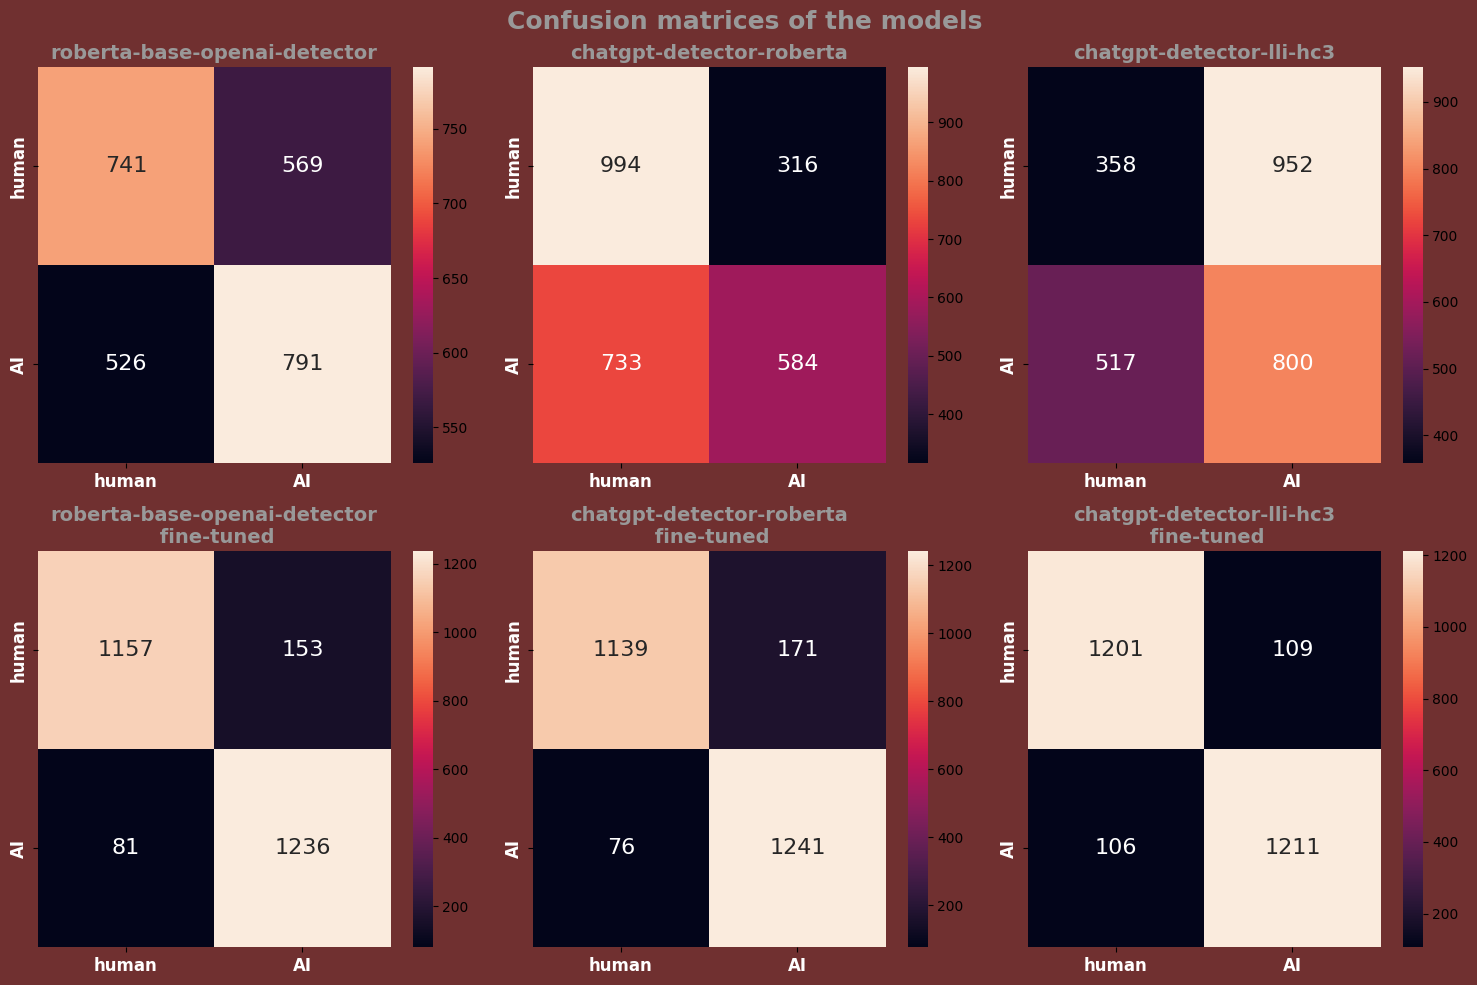

In [13]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Confusion matrices of the models', fontsize=18, fontweight='bold', color='#999999')
fig.set_facecolor('#703030')
for i in range(len(model_names)):
    sns.heatmap(model_confusion_matrices[model_names[i]], fmt='d', annot=True, ax=ax[0][i], annot_kws={"size": 16})
    ax[0][i].set_title(model_names[i], fontweight='bold', fontsize=14, color='#999999')
    sns.heatmap(fine_tuned_model_confusion_matrices[model_names[i]], fmt='d', annot=True, ax=ax[1][i], annot_kws={"size": 16})
    ax[1][i].set_title(model_names[i] + '\n fine-tuned', fontweight='bold', fontsize=14, color='#999999')

    # change x and y labels. map 0 to 'human' and 1 to 'AI'
    ax[0][i].set_xticklabels(['human', 'AI'], fontweight='bold', fontsize=12, color='white')
    ax[0][i].set_yticklabels(['human', 'AI'], fontweight='bold', fontsize=12, color='white')
    ax[1][i].set_xticklabels(['human', 'AI'], fontweight='bold', fontsize=12, color='white')
    ax[1][i].set_yticklabels(['human', 'AI'], fontweight='bold', fontsize=12, color='white')

plt.tight_layout()
plt.show()

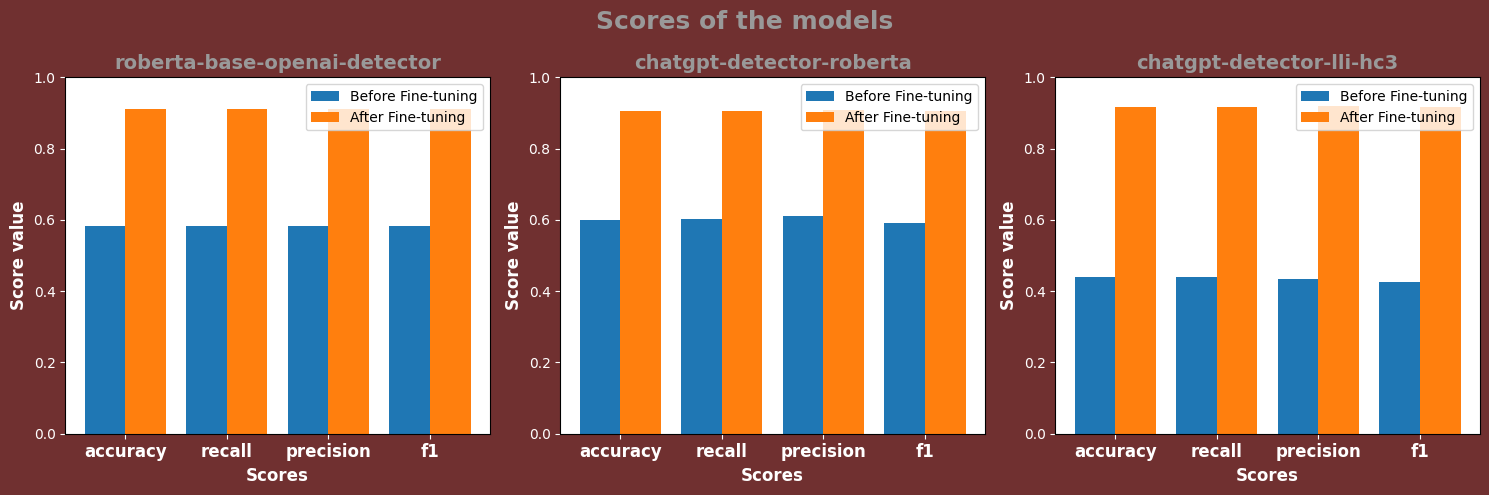

In [14]:
# Plotting the bar plots side by side
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Scores of the models', fontsize=18, fontweight='bold', color='#999999')
fig.set_facecolor('#703030')

for i, model_name in enumerate(model_names):
    scores_before = list(model_scores_before_finetuning[model_name].values())
    scores_after = list(model_scores[model_name].values())
    labels = list(model_scores_before_finetuning[model_name].keys())

    # Create an array with the position of each bar along the x-axis
    x = np.arange(len(labels))

    # Plot each bar plot
    ax[i].bar(x - 0.2, scores_before, width=0.4, label='Before Fine-tuning')
    ax[i].bar(x + 0.2, scores_after, width=0.4, label='After Fine-tuning')

    ax[i].set_title(model_name, fontweight='bold', fontsize=14, color='#999999')
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(labels, fontweight='bold', fontsize=12, color='white')
    ax[i].set_ylim(0, 1)
    ax[i].set_xlabel('Scores', fontweight='bold', fontsize=12, color='white')
    ax[i].set_ylabel('Score value', fontweight='bold', fontsize=12, color='white')
    ax[i].tick_params(axis='x', colors='white')
    ax[i].tick_params(axis='y', colors='white')
    ax[i].legend()

plt.tight_layout()
plt.show()